# Style transfer

In [1]:
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage

In [3]:
torch.backends.cudnn.benchmark = True

## Data

In [4]:
PATH = Path('data/imagenet/')

In [5]:
 TRN_PATH = PATH/'train'

In [6]:
img_filename = TRN_PATH/'n01558993'/'n01558993_9684.JPEG'

In [7]:
img = open_image(img_filename)

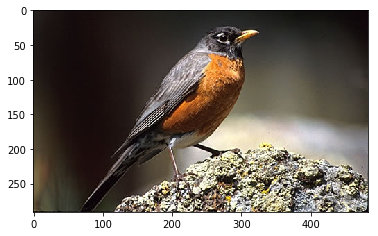

In [8]:
plt.imshow(img)

In [9]:
model = vgg16(pre=True).cuda().eval()

In [10]:
set_trainable(model, False)

In [11]:
sz = 228

In [12]:
train_tfms, val_tfms = tfms_from_model(vgg16, sz)

In [13]:
transformed_img = val_tfms(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


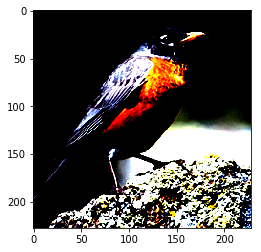

In [14]:
plt.imshow(transformed_img.transpose(1,2,0))

In [15]:
transformed_img.shape

(3, 228, 228)

## Create a random image

In [16]:
start_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)

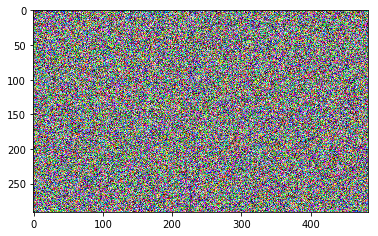

In [17]:
plt.imshow(start_img)

Hint: training starts much better if the picture is blurred/more even looking

In [18]:
start_img = scipy.ndimage.filters.median_filter(start_img, [8, 8, 1])

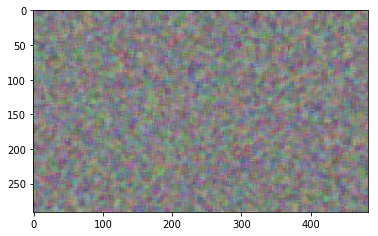

In [19]:
plt.imshow(start_img)

**We convert this starting image to a variable that *requires gradients*!**

In [20]:
start_img = val_tfms(start_img)/2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


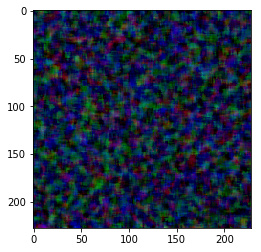

In [21]:
plt.imshow(start_img.transpose(1,2,0))

In [22]:
start_img_var = V(start_img[None], requires_grad=True)

In [23]:
start_img_var.shape

torch.Size([1, 3, 228, 228])

## Content loss: 
**returns a lower number if the picture looks more like the bird. We use a 'perceptual loss' which means that instead of comparing the pixel values of the generated image to the bird image (which would give an exact copy of the bird), we calculate the loss from specific (arbitrarily chosen) activations in a later layer of a neural network. If two pictures cause 'similar activations' they should look similar while not being the same.**

**Let's grab an activation from a later layer:**

In [24]:
model = nn.Sequential(*list(model.children())[:37])

**Let's calculate the target activations of our bird image. Gradients not required!**

In [25]:
targ_act = model(V(transformed_img[None], requires_grad=False))  # slicing with None creates a unit axis <=> bs=1

In [26]:
targ_act.shape

torch.Size([1, 512, 14, 14])

**Loss function:**

In [27]:
def content_loss(x):
    return F.mse_loss(model(x), targ_act) * 1000
# without the 1000 the loss would be of order 1e-7. Pretty small when using float32. Especially important when using HALF PRECISION on Volta GPUs

**Optimizer: LBFGS approximates the Hessian. 'L' stands for limited, only keeps track of certain number of gradients for the sake of memory.**

In [28]:
optimizer = optim.LBFGS([start_img_var], lr=0.5)  # pass a list of variables that require gradients

In [29]:
n_iter = 0

In [30]:
def step(loss_func):
    global n_iter
    optimizer.zero_grad()
    loss = loss_func(start_img_var)
    loss.backward()
    n_iter += 1
    if n_iter % 100 == 0: print(f'Iteration: {n_iter}, loss {loss.data[0]}')
    return loss

```
Arguments of THIS optimizer.step:
    closure (callable): A closure that reevaluates the model
        and returns the loss.
```

In [31]:
while n_iter < 1000:
    optimizer.step(partial(step, content_loss))

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 100, loss 0.9094685316085815
Iteration: 200, loss 0.39784175157546997
Iteration: 300, loss 0.2516191601753235
Iteration: 400, loss 0.19179299473762512
Iteration: 500, loss 0.15935708582401276
Iteration: 600, loss 0.139164537191391
Iteration: 700, loss 0.12542252242565155
Iteration: 800, loss 0.11527569591999054
Iteration: 900, loss 0.10697761178016663
Iteration: 1000, loss 0.10044992715120316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


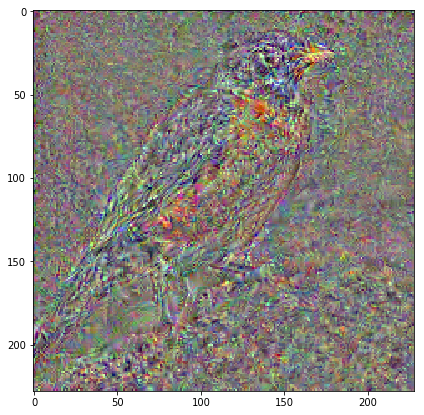

In [32]:
plt.figure(figsize=(7,7))
plt.imshow(val_tfms.denorm(start_img_var.data.cpu().numpy()[0].transpose(1,2,0)))

**Until now we simply took the activations from an arbitrarily chosen layer. It makes sense to assume that the result will improve if we compare the activations of specific layer (chosen through experimentation) or even of several layers. Pytorch offers a very convenient way of accessing them called 'forward hook'. Let's you grab whatever you want in the forward pass. 'Backward hooks' let you do the same for the backward pass.**

When the forward method of `module` is called, the hook calls `self.hook_fn` which stores the output in an attribute called `features`:

In [33]:
class SaveFeatures():
    features = None
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True).cuda()
    def close(self):
        self.hook.remove()

In [34]:
model = vgg16(pre=True).cuda().eval()

In [35]:
set_trainable(model, False)

```
def set_trainable_attr(m,b):
    m.trainable=b
    for p in m.parameters(): p.requires_grad=b
```

In [36]:
block_ends = [i - 1 for i, o in enumerate(list(model.children())) if isinstance(o, nn.MaxPool2d)]

**Grabs indices of all layers before MaxPool. Layers before MaxPool or stride 2 conv are interesting because they are the most rich/complete representation of the image at that grid size.**

In [37]:
block_ends

[5, 12, 22, 32, 42]

In [38]:
feat = SaveFeatures(list(model.children())[block_ends[3]])

In [39]:
def get_start():
    start_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    start_img = scipy.ndimage.filters.median_filter(start_img, [15, 15, 1])
    start_img_var = V(val_tfms(start_img / 2)[None], requires_grad=True)
    return start_img_var, optim.LBFGS([start_img_var])

In [40]:
start_img_var, optimizer = get_start()

In [41]:
all_targ_act = model(V(transformed_img[None], requires_grad=False))  # We are not interested in the result all_targ_act but instead in the activations stored in feat.features by the hook

In [42]:
targ_act = V(feat.features.clone())

In [43]:
targ_act.shape

torch.Size([1, 512, 28, 28])

In [44]:
def content_loss2(x):
    model(x)  
    # does a forward pass and throws away results. next line gets the activations from the forward hook
    output = feat.features  # last time we just used model(x) without the hook
    return F.mse_loss(output, targ_act) * 1000

In [45]:
n_iter = 0

In [46]:
while n_iter < 1000:
    optimizer.step(partial(step, content_loss2))

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 100, loss 0.21816112101078033
Iteration: 200, loss 0.09391652792692184
Iteration: 300, loss 0.060370903462171555
Iteration: 400, loss 0.044551536440849304
Iteration: 500, loss 0.03566975146532059
Iteration: 600, loss 0.029947463423013687
Iteration: 700, loss 0.026218777522444725
Iteration: 800, loss 0.023552680388092995
Iteration: 900, loss 0.02155415527522564
Iteration: 1000, loss 0.01993902213871479


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


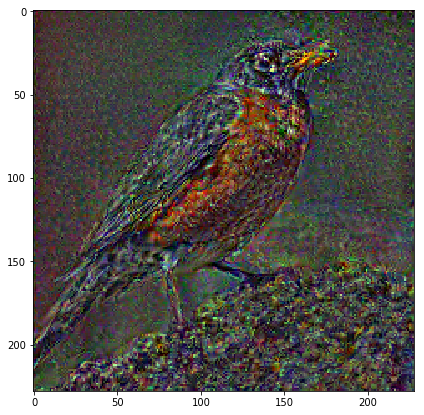

In [47]:
plt.figure(figsize=(7,7))
plt.imshow(val_tfms.denorm(start_img_var.data.cpu().numpy()[0].transpose(1,2,0)))

This result is better than the previous one because we chose to compare the activations from an earlier layer which is closer to the pixels.

In [48]:
feat.close()

## Style loss 
**returns a lower number if the picture is closer to Van Gogh's style**

**However, we have to do this in a different way than the content loss. Otherwise we end up with an image that has a similar *content* than the style image. We do *not* want that. We do not want the content, we want the style. We therefore need to throw away spatial information and find a non spatial representation of how the different channels in the layer whe chose correlate with each other. *Gram matrix*: The diagonal of the Gram matrix says how active each channel is (L2 norm of each channel). The non-diagonal elements say which channels 'appear' (show high activations) together. Two different images that have the same style are expected to have similar Gram matrices.**

In [49]:
STYLE_PATH = Path('data/style_transfer')

In [50]:
style_fn = STYLE_PATH/'starry_night.jpg'

In [51]:
style_img = open_image(style_fn)

In [52]:
style_img.shape, img.shape

((500, 800, 3), (291, 483, 3))

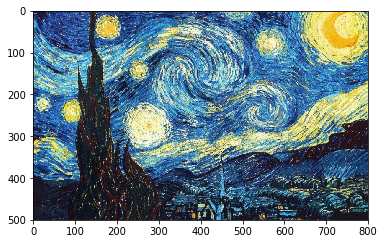

In [53]:
plt.imshow(style_img)

In [54]:
def match_dim(src, targ):
    h, w, _ = src.shape
    targ_h, targ_w, _ = targ.shape
    ratio = max(h/targ_h, w/targ_w)
    resized = cv2.resize(targ, (int(targ_w * ratio), int(targ_h * ratio)))
    return resized[:h, :w]

In [55]:
style = match_dim(img, style_img)

In [56]:
style.shape, img.shape

((291, 483, 3), (291, 483, 3))

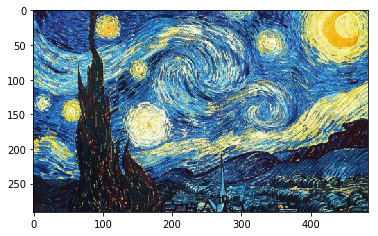

In [57]:
plt.imshow(style)

In [58]:
model = vgg16(pre=True).cuda().eval()
set_trainable(model, False)

In [59]:
start_img_var, optimizer = get_start()

In [60]:
feat = [SaveFeatures(list(model.children())[i]) for i in block_ends]

In [61]:
feat

In [62]:
transformed_style_img = val_tfms(style_img)

In [63]:
transformed_style_img.shape

(3, 228, 228)

**Activations returned by hooks for our style image (starry night).**

In [64]:
model(V(transformed_style_img[None], requires_grad=False))
targ_styles = [V(o.features.clone()) for o in feat]

In [65]:
[o.shape for o in targ_styles]

[torch.Size([1, 64, 228, 228]),
 torch.Size([1, 128, 114, 114]),
 torch.Size([1, 256, 57, 57]),
 torch.Size([1, 512, 28, 28]),
 torch.Size([1, 512, 14, 14])]

In [66]:
def gram_matrix(input):
    bs, channels, h, w = input.size()
    x = input.view(bs * channels, -1)  # makes every channel a vector of size h * w. Gram matrix then has size bs * channels
    return torch.mm(x, x.t()) / input.numel() * 1e6

# normalize by number of elements in tensor and multiply by large number so that loss is not so small

In [67]:
def gram_mse_loss(input, target):
    return F.mse_loss(gram_matrix(input), gram_matrix(target))

In [68]:
def style_loss(x):
    model(x)
    # does a forward pass and throws away results. next line gets the activations from the forward hooks
    outputs = [o.features for o in feat]  # goes through all SaveFeatures objects in feat and makes vars from their self.features attributes.
    losses = [gram_mse_loss(o, s) for o, s in zip(outputs, targ_styles)]
    return sum(losses)  # maybe its worth summing them up with different weights

In [69]:
n_iter = 0

In [70]:
while n_iter < 1000:
    optimizer.step(partial(step, style_loss))

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 100, loss 2166.326904296875
Iteration: 200, loss 287.3253479003906
Iteration: 300, loss 92.67385864257812
Iteration: 400, loss 39.410919189453125
Iteration: 500, loss 23.397254943847656
Iteration: 600, loss 17.404830932617188
Iteration: 700, loss 14.595085144042969
Iteration: 800, loss 12.921637535095215
Iteration: 900, loss 11.829744338989258
Iteration: 1000, loss 11.078838348388672


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


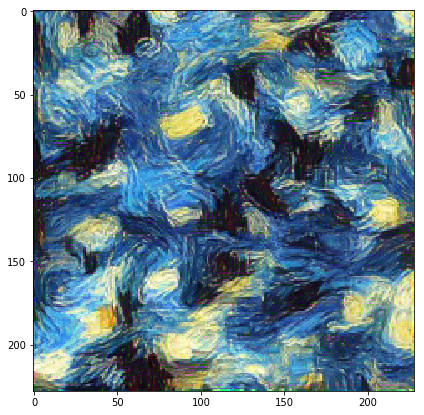

In [71]:
plt.figure(figsize=(7,7))
plt.imshow(val_tfms.denorm(start_img_var.data.cpu().numpy()[0].transpose(1,2,0)))

In [72]:
for o in feat:
    o.close()

## Putting it all together: Style transfer

In [118]:
start_img_var, optimizer = get_start()

In [119]:
feat = [SaveFeatures(list(model.children())[i]) for i in block_ends]

**Activations returned by hooks for our content image (bird).**

In [120]:
model(V(transformed_img[None], requires_grad=False))
target_activations = [V(o.features.clone()) for o in feat]

In [121]:
[o.shape for o in target_activations]

[torch.Size([1, 64, 228, 228]),
 torch.Size([1, 128, 114, 114]),
 torch.Size([1, 256, 57, 57]),
 torch.Size([1, 512, 28, 28]),
 torch.Size([1, 512, 14, 14])]

In [122]:
def style_transfer_loss(x):
    model(start_img_var)
    outputs = [o.features for o in feat]  # activations returned by hooks when forwarding our random image through network
    
    # Style loss:
    style_losses = [gram_mse_loss(o, s) for o, s in zip(outputs, targ_styles)]
    style_loss = sum(style_losses)
    
    # Content loss
    content_loss = F.mse_loss(outputs[3], target_activations[3]) * 1e6
    
    return content_loss + style_loss

In [123]:
n_iter = 0

In [124]:
while n_iter < 2000:
    optimizer.step(partial(step, style_transfer_loss))

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 100, loss 5614.78857421875
Iteration: 200, loss 2017.3017578125
Iteration: 300, loss 1467.4425048828125
Iteration: 400, loss 1240.6949462890625
Iteration: 500, loss 1125.92919921875
Iteration: 600, loss 1057.936767578125
Iteration: 700, loss 1014.4701538085938
Iteration: 800, loss 986.0365600585938
Iteration: 900, loss 964.1765747070312
Iteration: 1000, loss 948.9663696289062
Iteration: 1100, loss 936.429931640625
Iteration: 1200, loss 926.2142333984375
Iteration: 1300, loss 917.462890625
Iteration: 1400, loss 910.34765625
Iteration: 1500, loss 904.416259765625
Iteration: 1600, loss 898.705810546875
Iteration: 1700, loss 893.8377685546875
Iteration: 1800, loss 889.456787109375
Iteration: 1900, loss 885.6329345703125
Iteration: 2000, loss 882.267822265625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 227.5, 227.5, -0.5)

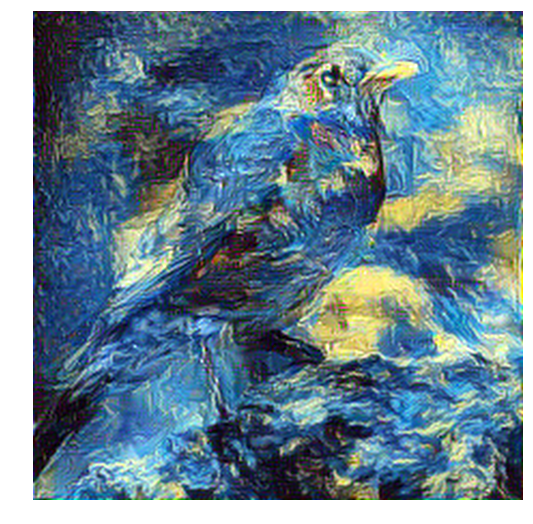

In [125]:
plt.figure(figsize=(9,9))
plt.imshow(val_tfms.denorm(start_img_var.data.cpu().numpy()[0].transpose(1,2,0)), interpolation='lanczos')
plt.axis('off')